<a href="https://colab.research.google.com/github/TimilsinaSushil/Thesis/blob/main/Person_Hyperparameter_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install inltk
!pip install bayesian-optimization



In [ ]:
from inltk.inltk import setup
from inltk.inltk import tokenize
from inltk.inltk import get_embedding_vectors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import asyncio
asyncio.set_event_loop(asyncio.new_event_loop())
setup('ne')


In [372]:
! gdown --id 116JOC660mWu8DdiLwS8-CLDZdfDPDoeG
df = pd.read_csv('QSN.csv')


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=116JOC660mWu8DdiLwS8-CLDZdfDPDoeG
To: /content/QSN.csv
100% 1.05M/1.05M [00:00<00:00, 124MB/s]


['individual' 'inventor' 'discoverer' 'appellation']


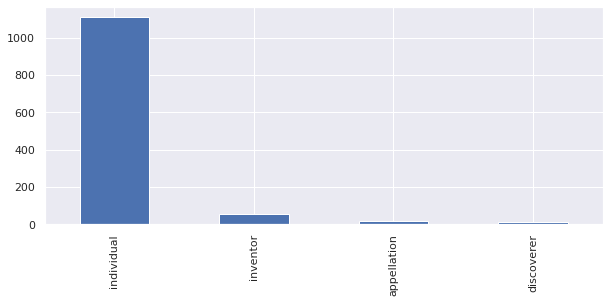

In [373]:
#fine type filtering
df=df[df['CoarseType'].isin(['person'])]
df=df[df['FineType'].isin(['individual','inventor','discoverer','appellation'])]
fine_type=df['FineType'].unique()
output_shape=len(fine_type)
print(fine_type)
plt.figure(figsize=(10,4))
df.FineType.value_counts().plot(kind='bar');


**Text Preprocessig**

In [374]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [375]:
#removing text inside brackets and quotes
import re
def removeTextInsideQuotesAndBrackets(text):
  text=re.sub("[\(\[].*?[\)\]]", "", text)
  text=re.sub("\'.*?\'","",text)
  text=re.sub('\".*?\"',"",text)
  return text

In [376]:
def removeKo(text):
  words= text.split()
  text=[]
  for word in words:
    length=len(word)
    if(length > 2):
      if(word[-2]=='क' and word[-1]=='ो'):
        if(word!='कसको'):
          word= word[:length-2]
    text.append(word)
  text=' '.join([word for word in text])
  # print(text)
  return text




In [377]:
def preprocessing(questions):
  questions=questions.apply(removeTextInsideQuotesAndBrackets)
  questions = questions.apply(removeKo)
  #tokenization
  questions= questions.apply(lambda x: tokenize(x,'ne'))
  #removing duplicates
  questions= questions.apply(lambda x: list(dict.fromkeys(x)))
  
  questions=questions.apply(lambda x: ' '.join(x).replace('▁','').split())
  questions=questions.apply(lambda x: ' '.join(x))

  #removing numbers
  questios=questions.apply(lambda x: ''.join(c for c in x if not c.isdigit()))
  #removing punctuation
  punctuation=['!','"','#','$','&',"'",'(',')','*','+',',','-','.','/',':',';','<','=','>','?','@','[',"]",'^','_','`','{','|','}','~']
  questions = questions.apply(lambda x: ''.join(c for c in x if c not in punctuation))

  #removing stopwords
  WHWORDS = ['कुन','कहिले','के','कति','को','कसले','कहाँ','कसलाई','कसको','कस्तो','कति','कसरी','किन','कता']
  STOPWORDS = stopwords.words('nepali')
  # Removig WH words from STOPWORDS
  for word in WHWORDS:
    if word in STOPWORDS: STOPWORDS.remove(word)

  STOPWORDS=set(STOPWORDS)
  def clean_text(text):
      text=' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwords from text
      return text
  questions = questions.apply(clean_text)
  return questions



In [378]:
df['Questions'] = preprocessing(df['Questions'])

dataset=df

df.head()

,Questions,Answer,CoarseType,FineType,WhWord,Domain
6,विश्वका ८ हजार मिटर अग्ला १४ ओ ट ै हिमाल आरोहण...,निर्मल पुर्जा,person,individual,को,Miscellaneous
15,श्रीलंका आयोजित पर् फ र्म अवार्ड जित्ने नेपाल ...,स्वस्तिमा खड्का,person,individual,को,Miscellaneous
23,वासुदेव मुना ल बाल प्रतिभा पुरस्कार २०७६ कस प्...,आयुस केसी,person,individual,कसलाई,Miscellaneous
36,N R N अध्यक्ष नियुक्त व्यक्ति को,कुमार पन्त,person,individual,को,Miscellaneous
47,फोर्ब्स सन् २०१९ सार्वजनिक सर्वाधिक कम ाइ विश्...,लियोनल मेसि,person,individual,को,Sports


In [379]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Questions'])
vocab_size=len(tokenizer.word_index)
sequences = tokenizer.texts_to_sequences(df['Questions'])
from keras.preprocessing.sequence import pad_sequences
maxlen = max([len(i) for i in sequences])
padded_sequences = pad_sequences(sequences, maxlen)

**One hot encoding of labels**

In [380]:
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
le = preprocessing.LabelEncoder()
y=df.FineType
# print(y.unique())
y = le.fit_transform(y)

**SVM**

In [381]:
def svm(k_fold,test_size):
  from sklearn.model_selection import train_test_split
  from sklearn.pipeline import Pipeline
  from sklearn.feature_extraction.text import TfidfTransformer
  from sklearn.feature_extraction.text import CountVectorizer
  from sklearn.svm import SVC
  from sklearn.naive_bayes import MultinomialNB
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import fbeta_score
  from sklearn.metrics import classification_report
  from sklearn.ensemble import RandomForestClassifier
  import random 
  test_size=0.30
  k_fold = 5
  X = dataset.Questions
  y = dataset.FineType

  # Splitting test set
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) 

  metrics = []
  skf= StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=1)
  X=np.array(X_train)
  y=np.array(y_train)

  # Defining Model
  model = Pipeline([('vect', CountVectorizer()),
              ('tfidf', TfidfTransformer()),
              ('clf', MultinomialNB()),
              ]) 

    
    #gaussian
    #sigmoid
  #model defination finished


  # K fold cross validation
  for train_index, validation_index in skf.split(X, y):
      # print("TRAIN:", train_index, "VALIDATION:", validation_index)
      X_train, X_validation = X[train_index], X[validation_index]
      y_train, y_validation = y[train_index], y[validation_index]
  #   # train the model
      model.fit(X_train,y_train)
  #   # validate the model 
      y_pred_class_for_validation = model.predict(X_validation)
      metrics.append(accuracy_score(y_validation, y_pred_class_for_validation))
      # print(classification_report(y_test, y_pred_class,target_names=coarse_type))
      




  metrics = np.array(metrics)
  # print('Validation Accuracy for each Iteration',metrics)
  # print('Mean accuracy for validation set: ', np.mean(metrics, axis=0))
  # print('Std for accuracy: ', np.std(metrics, axis=0))
  # print('---------------------------------------------------------------------------------')

  y_pred = model.predict(X_test)

  test_accuracy = accuracy_score(y_pred, y_test)
  # print('Test Accuracy : %s' % test_accuracy)
  # print(classification_report(y_test, y_pred,target_names=fine_type))

  # cf_matrix = confusion_matrix(y_test, y_pred, labels=fine_type)
  # print(cf_matrix)

  # import seaborn as sns
  # plt.figure(figsize=(8,7))
  # actual_data= ['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']
  # predicted_data= ['temporal' 'location' 'numerical' 'person' 'organization' 'explanation' 'miscellaneous']
  # cm = confusion_matrix(actual_data, predicted_data)
  # ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
  # ax.set_title('Confusion Matrix')
  # ax.set_xlabel('Predicted Intent')
  # ax.set_ylabel('Actual Intent')
  # ax.xaxis.set_ticklabels(['TEM','LOC','NUM','PER','ORG','EXP','MISC'])
  # ax.yaxis.set_ticklabels(['TEM','LOC','NUM','PER','ORG','EXP','MISC'])
  # plt.show()
  
  return test_accuracy


**Random Forest**

In [382]:
def randomForest(k_fold,test_size,n_estimators):
  from sklearn.model_selection import train_test_split
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import fbeta_score
  from sklearn.metrics import classification_report
  from sklearn.ensemble import RandomForestClassifier
  
  x=padded_sequences
  test_size=0.2
  k_fold=5
  # max_depth=2
  n_estimators=100

  x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=test_size) 
  metrics = []
  skf= StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)


  #Create a Gaussian Classifier
  model=RandomForestClassifier(n_estimators=n_estimators)

   # K fold cross validation
  for train_index, validation_index in skf.split(x_train, y_train):
      # print("TRAIN:", train_index, "VALIDATION:", validation_index)
      X_train, X_validation = x_train[train_index], x_train[validation_index]
      Y_train, Y_validation = y_train[train_index], y_train[validation_index]
     
  #   # train the model
      model.fit(X_train,Y_train)
  #   # validate the model 
      Y_pred_class_for_validation = model.predict(X_validation)
      metrics.append(accuracy_score(Y_validation, Y_pred_class_for_validation))
      # print(classification_report(y_test, y_pred_class,target_names=coarse_type))

  # metrics = np.array(metrics)
  # print('Validation Accuracy for each Iteration',metrics)
  # print('Mean accuracy for validation set: ', np.mean(metrics, axis=0))
  # print('Std for accuracy: ', np.std(metrics, axis=0))
  # print('---------------------------------------------------------------------------------')

 

  y_pred=model.predict(x_test)
  test_accuracy=accuracy_score(y_test, y_pred)

  # print("Test Accuracy:",test_accuracy)
  return test_accuracy

**DNN**

In [383]:

def dnn(k_fold,test_size,epochs,learning_rate,batch_size,vect_dim,neurons,dropout):
  from keras.models import Sequential
  from keras.layers import Dense, Flatten, Dropout
  from keras.layers.embeddings import Embedding
  from sklearn.model_selection import train_test_split
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import fbeta_score
  from sklearn.metrics import classification_report

  le = preprocessing.LabelEncoder()
  y=df.FineType
  # print(y.unique())
  y = le.fit_transform(y)
  y = to_categorical(y) 

  test_size=0.2
  k_fold=5

  epochs=20
  learning_rate= 0.002
  batch_size=40
  vect_dim=32
  neurons=128
  dropout=0.2



  x=padded_sequences;
  # print(x)
  # print(y)
  x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=test_size) 
  acc = []
  val = []
  skf= StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=42)
  # x=np.array(x_train)
  # y=np.array(y_train)

  max_len = max([len(i) for i in sequences])
  # print(max_len)
  # from keras.optimizers import Adam
  model = Sequential() 
  model.add(Embedding(vocab_size + 1, vect_dim, input_length=max_len)) 
  model.add(Flatten())
  model.add(Dense(neurons, activation='relu'))
  model.add(Dropout(dropout))
  # print(output_shape)
  model.add(Dense(output_shape, activation='softmax'))
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy']) 
  #default value of learning rate will be 0.001
  #adam is a variant of SGD(Sochastic gradient descent). Learning rate should be between (0.0001 to 0.1).Objective: Minimize the loss between actual output and predicted output.
  model.optimizer.lr=learning_rate
  # model.summary()

  # K fold cross validation
  i=0
  for train_index, validation_index in skf.split(x_train, y_train.argmax(1)):
      i=i+1
      # print("TRAIN:", train_index, "VALIDATION:", validation_index)
      x_train, x_validation = x[train_index], x[validation_index]
      y_train, y_validation = y[train_index], y[validation_index]
      hist = model.fit(x_train, y_train, validation_data=(x_validation,y_validation), epochs=epochs, batch_size=batch_size, verbose=0)
      ac = hist.history['categorical_accuracy']
      # print('Average training accuracy :' +str(sum(ac)/len(ac)))
      vl = hist.history['val_categorical_accuracy']
      # print('Average validation accuracy :' + str(sum(vl)/len(vl)))
      # ep = range(1, len(ac) + 1)
      # plt.figure()
      # plt.plot(ep, ac, '-', label='Training accuracy')
      # plt.plot(ep, vl, ':', label='Validation accuracy')
      # plt.title('Training and Validation Accuracy for set '+ str(i))
      # plt.xlabel('Epoch')
      # plt.ylabel('Accuracy')
      # plt.legend(loc='lower right')
      # plt.plot()
      # acc.extend(ac);
      # val.extend(vl)


  # plt.figure()
  # epochs = range(1, len(acc) + 1)
  # plt.plot(epochs, acc, '-', label='Training accuracy')
  # plt.plot(epochs, val, ':', label='Validation accuracy')
  # plt.title('Overall Training and Validation Accuracy')
  # plt.xlabel('Epoch')
  # plt.ylabel('Accuracy')
  # plt.legend(loc='lower right')
  # plt.plot()


  y_pred = model.predict(x_test)

  test_accuracy = accuracy_score(y_pred.argmax(axis=1), y_test.argmax(axis=1))

  beta_score=fbeta_score( y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted', beta=1)
  # print('Test Accuracy : %s' % test_accuracy)
  # # print(y_pred.argmax(axis=1))
  # # print(y_test.argmax(axis=1))
  # labels=y.argmax(axis=1)
  # labels=le.inverse_transform(labels)
  # labels=np.unique(labels)
  # # print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=labels))

  # mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1),labels=le.fit_transform(df.CoarseType.unique()))
  # import seaborn as sns
  # plt.figure(figsize=(8,7))
  # sns.set()
  # sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=df.CoarseType.unique(), yticklabels=df.CoarseType.unique())

  # plt.xlabel('Predicted label')
  # plt.ylabel('Actual label')

  # return test_accuracy

  return beta_score

In [387]:
#SVM
from bayes_opt import BayesianOptimization
pbounds = {
    'k_fold': (5, 10), 
    'test_size':(20,50),
    }
optimizer_svm = BayesianOptimization(
    f=svm,
    pbounds=pbounds,
    verbose=2, 
    random_state=42,
)
optimizer_svm.maximize(init_points = 0, n_iter = 20)
print("Best result: {}; Accuracy = {}.".format(optimizer_svm.max["params"], optimizer_svm.max["target"]))

|   iter    |  target   |  k_fold   | test_size |
-------------------------------------------------
|  1        |  0.9246   |  6.873    |  48.52    |
|  2        |  0.9413   |  8.365    |  35.92    |
|  3        |  0.9274   |  8.478    |  35.97    |
|  4        |  0.8994   |  5.507    |  35.65    |
|  5        |  0.9441   |  8.22     |  35.98    |
|  6        |  0.9441   |  8.13     |  35.74    |
|  7        |  0.9497   |  8.363    |  35.35    |
|  8        |  0.9274   |  8.053    |  35.16    |
|  9        |  0.9497   |  8.692    |  35.28    |
|  10       |  0.9134   |  6.976    |  34.62    |
|  11       |  0.9218   |  8.594    |  34.91    |
|  12       |  0.9497   |  8.02     |  24.55    |
|  13       |  0.9497   |  8.964    |  46.52    |
|  14       |  0.9358   |  8.558    |  35.48    |
|  15       |  0.9497   |  5.575    |  25.95    |
|  16       |  0.9413   |  9.777    |  27.84    |
|  17       |  0.9302   |  9.068    |  44.07    |
|  18       |  0.9413   |  6.042    |  43.25    |


In [388]:
#Random Forest
pbounds = {
    'k_fold': (5, 10), 
    'test_size':(20,50),
    # 'max_depth':(100,1000),
    'n_estimators':(100,1000),
    }
optimizer_rf = BayesianOptimization(
    f=randomForest,
    pbounds=pbounds,
    verbose=2, 
    random_state=42,
)
optimizer_rf.maximize(init_points = 0, n_iter = 20)
print("Best result: {}; Accuracy = {}.".format(optimizer_rf.max["params"], optimizer_rf.max["target"]))

|   iter    |  target   |  k_fold   | n_esti... | test_size |
-------------------------------------------------------------
|  1        |  0.9331   |  6.873    |  955.6    |  41.96    |
|  2        |  0.9331   |  9.857    |  669.2    |  49.58    |
|  3        |  0.9289   |  5.514    |  100.1    |  22.2     |
|  4        |  0.9372   |  6.963    |  954.1    |  41.37    |
|  5        |  0.9331   |  6.486    |  953.8    |  40.96    |
|  6        |  0.9414   |  9.47     |  875.4    |  32.4     |
|  7        |  0.9372   |  6.662    |  711.9    |  48.89    |
|  8        |  0.9414   |  5.472    |  821.1    |  37.87    |
|  9        |  0.9456   |  7.015    |  856.6    |  42.73    |
|  10       |  0.9372   |  8.052    |  299.3    |  49.28    |
|  11       |  0.9372   |  5.204    |  540.0    |  37.75    |
|  12       |  0.9414   |  6.541    |  875.0    |  22.82    |
|  13       |  0.9414   |  5.827    |  876.2    |  22.99    |
|  14       |  0.9414   |  6.564    |  855.8    |  43.21    |
|  15   

In [389]:
#DNN
pbounds = {
    'k_fold': (5, 10), 
    'test_size':(20,50),
    'epochs': (10,50), 
    'learning_rate':(0.0001,0.01),
    'batch_size': (10, 100), 
    'vect_dim':(8,128),
    'neurons':(8,128),
    'dropout':(0.2,0.8)
    }
optimizer_dnn = BayesianOptimization(
    f=dnn,
    pbounds=pbounds,
    verbose=2, 
    random_state=42,
)
optimizer_dnn.maximize(init_points = 0, n_iter = 5)
print("Best result: {}; Accuracy = {}.".format(optimizer_dnn.max["params"], optimizer_dnn.max["target"]))


|   iter    |  target   | batch_... |  dropout  |  epochs   |  k_fold   | learni... |  neurons  | test_size | vect_dim  |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  1.0      |  43.71    |  0.7704   |  39.28    |  7.993    |  0.001645 |  26.72    |  21.74    |  111.9    |
|  2        |  1.0      |  44.25    |  0.7151   |  40.18    |  5.092    |  0.001748 |  64.88    |  39.76    |  93.82    |
|  3        |  1.0      |  99.01    |  0.2426   |  24.83    |  9.238    |  0.004139 |  126.9    |  22.28    |  10.95    |
|  4        |  1.0      |  11.41    |  0.6315   |  11.84    |  9.459    |  0.009977 |  8.838    |  30.46    |  10.25    |
|  5        |  1.0      |  12.12    |  0.3873   |  15.88    |  5.539    |  0.000334 |  124.5    |  43.03    |  117.0    |
|  6        |  1.0      |  33.54    |  0.692    |  49.18    |  5.756    |  0.008449 |  97.7     |  39.55    |  116.8    |
Best result: {'batch_siz